<div style="color:#8b1538; font-size:32px;">Graphic representation using matplotlib and seaborn</div>

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.simulation.msprime as ms

<br>

In [21]:
params = []
for tau in np.arange(-4, 1, 0.1):
    for kappa in np.arange(1.3, 3, 0.1):
        params.append({'Tau': round(tau, 2), 'Kappa': round(kappa, 2)})
len(params)

850

In [3]:
df = pd.read_json("./Data/Msprime/SFS_decline-all.json")
df

,Parameters,SNPs,SFS observed,Time
0,"{'Tau': 0.0006309573, 'Kappa': 794.3282347243,...","[113150, 116532, 114647, 116306, 116412, 11620...","[[30953, 16069, 10868, 8137, 6273, 5294, 4575,...",24.8320
1,"{'Tau': 0.2511886432, 'Kappa': 0.0794328235, '...","[100997, 99466, 100709, 99501, 100594, 100420,...","[[57889, 18292, 7871, 4050, 2517, 1711, 1194, ...",12.5670
2,"{'Tau': 0.316227766, 'Kappa': 25.1188643151, '...","[100794, 100304, 103022, 100901, 98423, 99688,...","[[15352, 11604, 9637, 8927, 6651, 5945, 5360, ...",28.6893
3,"{'Tau': 125.8925411794, 'Kappa': 0.0125892541,...","[98875, 99308, 98674, 99759, 98143, 98094, 100...","[[27978, 13969, 8945, 7196, 5616, 4615, 4021, ...",25.0854
4,"{'Tau': 0.316227766, 'Kappa': 0.0316227766, 's...","[102071, 100481, 100882, 100755, 101432, 10017...","[[62306, 19866, 8336, 4030, 2191, 1233, 781, 5...",13.0820
...,...,...,...,...
4220,"{'Tau': 0.1995262315, 'Kappa': 0.6309573445000...","[100002, 99171, 99134, 99341, 101022, 101009, ...","[[33076, 14813, 8965, 6273, 5120, 4190, 3523, ...",34.4700
4221,"{'Tau': 0.0039810717, 'Kappa': 2.5118864315, '...","[99498, 99169, 101668, 100368, 99888, 101053, ...","[[28291, 13827, 9078, 6948, 5562, 4748, 4075, ...",24.7502
4222,"{'Tau': 50.1187233627, 'Kappa': 3.9810717055, ...","[100386, 99356, 99840, 99356, 100468, 100399, ...","[[28174, 14282, 9423, 7272, 5650, 4828, 3897, ...",33.2772
4223,"{'Tau': 0.1584893192, 'Kappa': 0.0630957344, '...","[100923, 101159, 98107, 101352, 99909, 100376,...","[[63305, 16006, 6034, 3060, 1974, 1454, 1231, ...",11.9568


<br>

# SFS shape verification

> Generate data

In [2]:
def simulation_parameters(sample, ne, rcb_rate, mu, length):
    """
    Set up the parametres for the simulation with msprime.
    """
    parameters = {
        "sample_size": sample, "size_population": ne, "rcb_rate": rcb_rate, "mu": mu,
        "length": length
    }
    return parameters


def generate_sfs():
    """
    Return
    ------
    sfs: dictionary
        sfs for various scenario - constant population, theorical sfs for any constant population, decline model,
        growth model and migration model (with no migration finto 2 from 1)
    parameters: dictionary
        specific value of tau & kappa for the growth and decline model
        specifiv value of m12, m21 & kappa for the migration model
    """
    # Dictionary
    sfs, parameters = {}, {}
    
    # Parameters for the simulation
    params_simulation = simulation_parameters(sample=10, ne=1, rcb_rate=2e-2, mu=2e-2, length=1e5)

    # Constant scenario
    sfs_cst = ms.msprime_simulation(model=ms.constant_model, params=params_simulation, debug=True)
    sfs['Constant model'] = sfs_cst
    
    # Theoretical SFS for any constant population
    sfs_theorique = [0] * (params_simulation["sample_size"] - 1)
    for i in range(len(sfs_theorique)):
        sfs_theorique[i] = 1 / (i+1)
    sfs['Theoretical model'] = sfs_theorique

    # Define tau & kappa for decline/growth scenario
    params_simulation.update({"Tau": 1.0, "Kappa": 10.0})

    sfs['Decline model'] = ms.msprime_simulation(model=ms.sudden_decline_model, params=params_simulation, debug=True)
    parameters['Decline model'] = {k: v for k, v in params_simulation.items() if k in ['Tau', 'Kappa']}

    sfs['Growth model'] = ms.msprime_simulation(model=ms.sudden_growth_model, params=params_simulation, debug=True)
    parameters['Growth model'] = {k: v for k, v in params_simulation.items() if k in ['Tau', 'Kappa']}

    # Migration scenario
    params_simulation.update({"Kappa": 10.0, "m12": 1.0, "m21": 0})
    
    sfs['Migration model'] = ms.msprime_simulation(model=ms.two_pops_migration_model, params=params_simulation, debug=True)
    parameters['Migration model'] = {k: v for k, v in params_simulation.items() if k in ['m12', 'm21', 'Kappa']}

    return sfs, parameters, {k: v for k, v in params_simulation.items() if k not in ['m12', 'm21', 'Kappa', 'Tau']}


def load_sfs(generate=False):
    if generate:
        all_sfs, params, params_simulation = generate_sfs()
        with open("./Data/Msprime/sfs_shape_verification", 'w') as filout:
            filout.write("SFS shape verification and simulations parameters - {}\n".format(params_simulation))
           
            for model, sfs in all_sfs.items():
                if model in params.keys():
                    filout.write("{} - {} - {}\n".format(model, sfs, params[model]))
                else:
                    filout.write("{} - {}\n".format(model, sfs))
    
    else:
        all_sfs, params = {}, {}
        with open("./Data/Msprime/sfs_shape_verification", 'r') as filin:
            lines = filin.readlines()
            params_simulation = ast.literal_eval(lines[0].strip().split(' - ')[1])
            
            for line in lines[1:]:
                tmp = line.strip().split(' - ')
                if tmp[0] not in ['Constant model', 'Theoretical model']:
                    params[tmp[0]] = ast.literal_eval(tmp[2])
                all_sfs[tmp[0]] = json.loads(tmp[1])
        
    return all_sfs, params, params_simulation

In [3]:
data = load_sfs()

<br>

> Plot data

In [4]:
def plot_sfs(data):
    """
    Graphic representation of Site Frequency Spectrum (SFS), save to the folder ./Figures.

    Parameter
    ---------
    sfs: list
        list of sfs to plot
    label: list
        the label of each sfs
    color: list
        the color of each curve
    style: list
        the linestyle
    title: string
        title of the plot
    """
    color = ["tab:blue", "tab:orange", "tab:red", "tab:green", "tab:gray"]
    
    # Set up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    
    cpt = 0
    for key, sfs in data[0].items():
        # Normalization of SFS - sum to 1
        normalized_sfs = [ele / sum(sfs) for ele in sfs]
        
        # Label
        if key in ['Constant model', 'Theoretical model']:
            label = key
        else:
            label = "{} - {}".format(key, data[1][key])
    
        # Plot
        plt.plot(normalized_sfs, color=color[cpt], label=label)
        
        cpt += 1
        
    # Caption
    plt.legend(loc="upper right", fontsize="x-large")

    # Label axis
    plt.xlabel("Allele frequency", fontsize="x-large")
    plt.ylabel("Percent of SNPs", fontsize="x-large")

    # X axis values
    x_ax, x_values = [], []
    for i in range(len(sfs)):
        x_ax.append(i)
        x_values.append("{}/{}".format(i+1, len(sfs)+1))
    plt.xticks(x_ax, x_values)

    # Title + show
    title = "Unfold SFS for various scenario with Ne={}, mu={}, rcb={}, L={}" \
        .format(data[2]['size_population'], data[2]['mu'], data[2]['rcb_rate'], data[2]['length'])
    plt.title(title, fontsize="xx-large")
    plt.show()

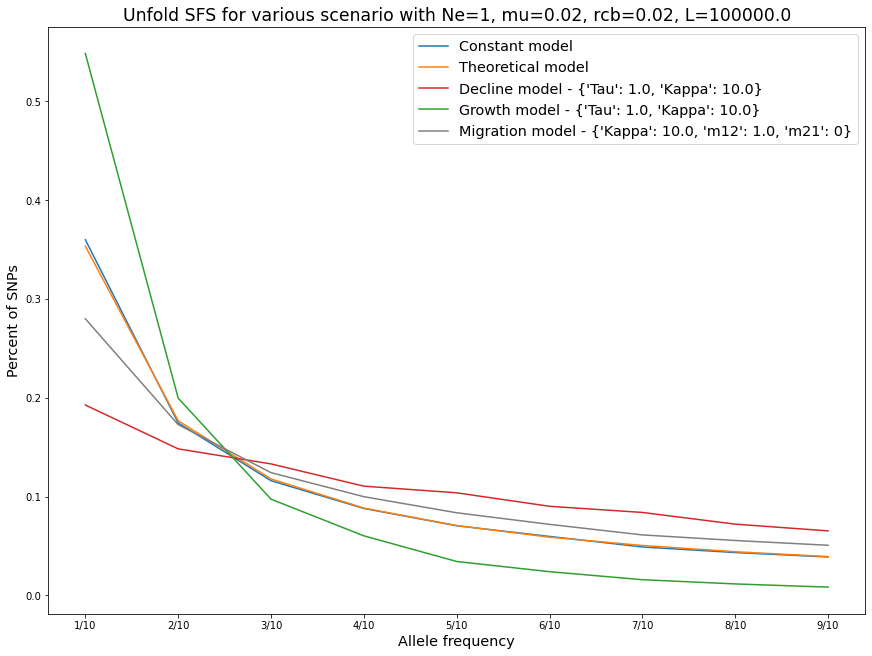

In [5]:
plot_sfs(data)

<br>

# Weighted square distance

The weighted square distance $\large{d^2}$ is:

1. Between the observed SFS $\large{\eta^{obs}}$ and the predicted SFS by model M1 $\large{\eta^{model}}$

\begin{equation}
\Large{ d^2(\eta^{model}, \eta^{obs}) = \sum_{i=1}^{n}{\frac{(\eta^{model}_i - \eta^{obs}_i)^2}{\eta^{model}_i }} }
\end{equation}

2. Between the inferred SFS of two models ($\large{\eta^{m2}}$ & $\large{\eta^{m1}}$)

\begin{equation}
\Large{ d^2(\eta^{m0}, \eta^{m1}) = \sum_{i=1}^{n}{\frac{(\eta^{m0}_i - \eta^{m1}_i)^2}{ (\eta^{m0}_i + \eta^{m1}_i) / 2 }} }
\end{equation}

Start the sum from 2 to ignore singletion (i=2).

<div class="alert alert-warning">Each SFS must be normalized</div>

In [9]:
def compute_weighted_square_distance(sfs):
    if "Observed" in sfs.keys():
        d2 = [
            np.power(eta_model - eta_obs, 2) / eta_model for eta_model, eta_obs in zip(sfs['Model'], sfs['Observed'])
        ]
    else:
        d2 = [
            np.power(eta_m0 - eta_m1, 2) / (np.mean([eta_m0, eta_m1])) for eta_m0, eta_m1 in zip(sfs['M0'], sfs['M1'])
        ]
    return d2


def data_weighted_square_distance(model):
    observed = pd.read_json("./Data/Msprime/sfs_{0}/SFS_{0}-all.json".format(model))
    
    for _, row in observed.iterrows():
        print(row)
        break

In [10]:
data_weighted_square_distance("decline")

Parameters      {'Tau': 0.0006309573, 'Kappa': 794.3282347243,...
SNPs            [113150, 116532, 114647, 116306, 116412, 11620...
SFS observed    [[30953, 16069, 10868, 8137, 6273, 5294, 4575,...
Time                                                       24.832
Name: 0, dtype: object


<br>

# SNPs distribution

> Load data

In [8]:
def load_data(model, path_data):
    data = pd.read_json(path_or_buf="{}SFS_{}-all.json".format(path_data, model), typ='frame')
    
    return data

<br>

> Data pre-processing

In [4]:
def percentile(centile):
    
    def percentile_(data):
        return np.percentile([np.log10(ele) for ele in data], centile)
    percentile_.__name__ = "centile {}%".format(centile)
    
    return percentile_

In [5]:
def data_preprocessing(sfs):
    """
    Pre processing for the plot.
    """
    # New pandas DataFrame
    data = pd.DataFrame()
    
    # Compute log10 of parameters - either (tau, kappa) or (m12, kappa)
    keys = sfs['Parameters'][0].keys()
    name = []
    for key in keys:
        if key in ['Tau', 'Kappa', 'm12']:
            name.append(key)
            data[key] = sfs['Parameters'].apply(lambda ele: ele[key])
    
    # Compute mean(SNPs)
    data['SNPs'] = sfs['SNPs']
    
    # Compute 
    data = data.groupby([name[0], name[1]]).agg([percentile(50)]).unstack(name[0])
    data.columns.name = data.columns.names[2]
    
    return data

<br>

> Plot data

In [6]:
def plot_snp_distribution(data, model):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Plot
    ax = sns.heatmap(data)
    
    # Name
    names = ["Log10({})".format(data.columns.name), "Log10({})".format(data.index.name)]
    
    # x-axis
    plt.xticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-4, 2.5, 0.7)], rotation='horizontal')
    plt.xlabel(names[0], fontsize="large")
    
    # y-axis
    ax.set_ylim(ax.get_ylim()[::-1])  # reverse y-axis
    plt.yticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-3.5, 3, 0.7)])
    plt.ylabel(names[1], fontsize="large")
    
    # Title
    title = "SNPs distribution in terms of {} & {} - {} model".format(names[0], names[1], model)
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.show()

<br>

### SNPs distribution - decline model

> By default

In [9]:
model, path_data = "decline", "./Data/Msprime/snp_distribution/sfs_decline-default/"
data = data_preprocessing(load_data(model, path_data))

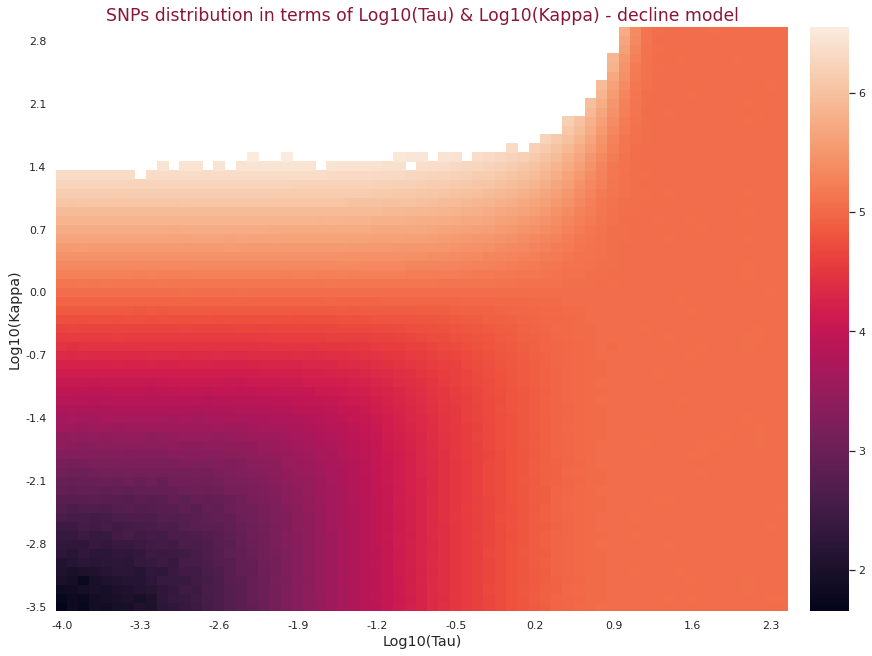

In [10]:
plot_snp_distribution(data, model)

<br>

> About 100 000 SNPs for each observed SFS

In [15]:
model, path_data = "decline", "./Data/Msprime/snp_distribution/sfs_decline/"
data = data_preprocessing(load_data(model, path_data))

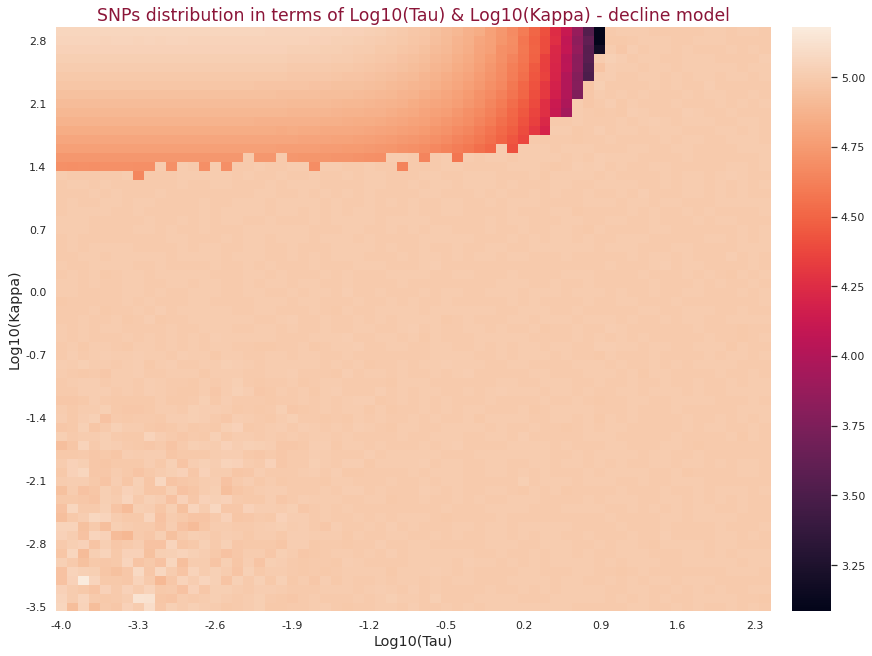

In [16]:
plot_snp_distribution(data, model)